<div style="font-weight: bold; text-align: center"> <font size="12", color='Green'> Waste Classification For Recycling </font> </div>

## <font color='Blue'> Importing of libraries </font>

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169, InceptionResNetV2, VGG19, InceptionV3, Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D
from PIL import Image
import gradio as gr

## <font color='Blue'> Data Loading & Pre Processing </font>

In [2]:
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
DATASET_PATH = 'images'
BATCH_SIZE = 20
NUM_CLASSES = 14
LEARNING_RATE = 0.0001

In [3]:
def load_images(dataset_path, image_size):
    images, labels = [], []
    class_names = os.listdir(dataset_path)
    
    print("Class Names:", class_names)
    
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        print("Class Path:", class_path)
        
        for root, _, files in os.walk(class_path):
            for file_name in files:
                file_path = os.path.join(root, file_name)
                
                image = cv2.imread(file_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    images.append(image)
                    labels.append(label)
                else:
                    print("Failed to load image:", file_path)
    
    return np.array(images, dtype='float32') / 255.0, np.array(labels), class_names

In [4]:
images, labels, class_names = load_images(DATASET_PATH, IMAGE_SIZE)
labels = to_categorical(labels, num_classes=len(class_names))

Class Names: ['aerosol_cans', 'aluminum_cans', 'cardboard_boxes', 'clothing', 'disposable_plastic_cutlery', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'paper_cups', 'plastic_shopping_bags', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'styrofoam_food_containers']
Class Path: images\aerosol_cans
Class Path: images\aluminum_cans
Class Path: images\cardboard_boxes
Class Path: images\clothing
Class Path: images\disposable_plastic_cutlery
Class Path: images\glass_beverage_bottles
Class Path: images\glass_cosmetic_containers
Class Path: images\glass_food_jars
Class Path: images\paper_cups
Class Path: images\plastic_shopping_bags
Class Path: images\plastic_straws
Class Path: images\plastic_trash_bags
Class Path: images\plastic_water_bottles
Class Path: images\styrofoam_food_containers


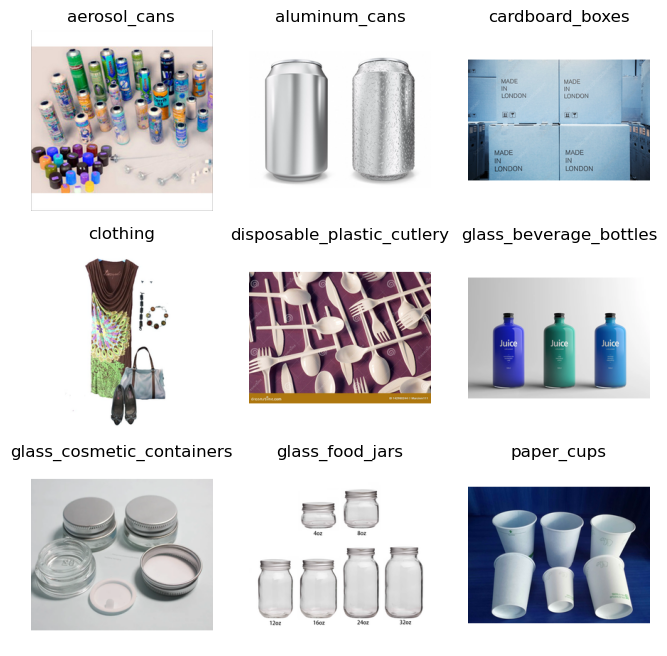

In [5]:
def visualize_images(images, labels, class_names, num_classes=9):
    plt.figure(figsize=(8, 8))
    j = 0
    for i in range(3, 250*num_classes , 250):
        plt.subplot(3, 3, j + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
        j += 1
    plt.show()
    
visualize_images(images, labels, class_names)

## <font color='Blue'> Spliting The Data </font>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### <font color='Blue'> Data Augmentation </font>

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

### <font color='Blue'> Model Evaluation class for the Classification Report and the Confusion Matrix </font>

In [10]:
class Evaluation:
    def __init__(self, model, X_test, y_test, class_names):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.y_pred = self.model.predict(self.X_test)
        self.y_pred_classes = np.argmax(self.y_pred, axis=1)
        self.y_true_classes = np.argmax(self.y_test, axis=1)

    def ClassificationReport(self):
        print("Classification Report:")
        print(classification_report(self.y_true_classes, self.y_pred_classes, target_names=self.class_names))

    def ConfusionMatrix(self):
        cm = confusion_matrix(self.y_true_classes, self.y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

### <font color='Blue'> Base Models </font>

In [ ]:
VGG19_base = VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
xception_base = Xception(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
DenseNet169_base = DenseNet169(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
InceptionResNetV2_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

<div style="font-weight: bold; text-align: center"> <font size="12", color='red'> Deep Learning Models </font> </div>

### Custom CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(14, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('customCNN3.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
history = model.fit(train_generator,validation_data=(X_val, y_val),epochs=150,callbacks=[checkpoint, reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.1585 - loss: 3.7853 - val_accuracy: 0.0857 - val_loss: 3.7521 - learning_rate: 0.0010
Epoch 2/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.2179 - loss: 2.8132 - val_accuracy: 0.0686 - val_loss: 3.9286 - learning_rate: 0.0010
Epoch 3/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.2476 - loss: 2.7121 - val_accuracy: 0.1229 - val_loss: 3.2753 - learning_rate: 0.0010
Epoch 4/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.2729 - loss: 2.5432 - val_accuracy: 0.2043 - val_loss: 2.9306 - learning_rate: 0.0010
Epoch 5/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3026 - loss: 2.4381 - val_accuracy: 0.1957 - val_loss: 2.7626 - learning_rate: 0.0010
Epoch 6/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.3729 - loss: 2.2400 - val_accuracy: 0.2314 - val_loss: 2.5240 - learning_rate: 0.0010
Epoch 7/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.3571 - loss: 2.1649 - 

Epoch 87/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8693 - loss: 0.3980 - val_accuracy: 0.6314 - val_loss: 1.5471 - learning_rate: 1.0000e-04
Epoch 88/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8520 - loss: 0.4632 - val_accuracy: 0.6586 - val_loss: 1.3379 - learning_rate: 1.0000e-04
Epoch 89/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8769 - loss: 0.4353 - val_accuracy: 0.6529 - val_loss: 1.3450 - learning_rate: 1.0000e-04
Epoch 90/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8517 - loss: 0.4648 - val_accuracy: 0.6357 - val_loss: 1.3940 - learning_rate: 1.0000e-04
Epoch 91/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8799 - loss: 0.3929 - val_accuracy: 0.6314 - val_loss: 1.4412 - learning_rate: 1.0000e-04
Epoch 92/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8736 - loss: 0.4388 - val_accuracy: 0.6614 - val_loss: 1.3986 - learning_rate: 1.0000e-04
Epoch 93/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - acc

Epoch 130/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9129 - loss: 0.2655 - val_accuracy: 0.5229 - val_loss: 2.2216 - learning_rate: 1.0000e-04
Epoch 131/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9159 - loss: 0.2651 - val_accuracy: 0.6614 - val_loss: 1.5250 - learning_rate: 1.0000e-04
Epoch 132/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9325 - loss: 0.2358 - val_accuracy: 0.6314 - val_loss: 1.6725 - learning_rate: 1.0000e-04
Epoch 133/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9230 - loss: 0.2404 - val_accuracy: 0.5986 - val_loss: 1.9005 - learning_rate: 1.0000e-04
Epoch 134/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9275 - loss: 0.2493 - val_accuracy: 0.6729 - val_loss: 1.4531 - learning_rate: 1.0000e-04
Epoch 135/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9285 - loss: 0.2474 - val_accuracy: 0.6371 - val_loss: 1.5708 - learning_rate: 1.0000e-04
Epoch 136/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/ste

In [13]:
cnnmodel = load_model('customCNN3.keras')

In [58]:
cnnmodel = load_model('customCNN3.keras')

loss, accuracy = cnnmodel.evaluate(X_val, y_val)

print(f'Custom CNN Test accuracy: {accuracy * 100:.2f}%')

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.6903 - loss: 1.4723
Custom CNN Test accuracy: 70.00%


In [72]:
evaluator = Evaluation(cnnmodel, X_val, y_val, class_names)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step


In [53]:
evaluator.ClassificationReport()

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.67      0.73      0.70        48
             aluminum_cans       0.62      0.73      0.67        48
           cardboard_boxes       0.80      0.72      0.75        60
                  clothing       0.55      0.87      0.67        47
disposable_plastic_cutlery       0.90      0.75      0.82        57
    glass_beverage_bottles       0.73      0.77      0.75        57
 glass_cosmetic_containers       0.61      0.51      0.56        39
           glass_food_jars       0.69      0.74      0.71        42
                paper_cups       0.65      0.58      0.61        53
     plastic_shopping_bags       0.62      0.59      0.61        51
            plastic_straws       0.71      0.60      0.65        42
        plastic_trash_bags       0.68      0.76      0.72        51
     plastic_water_bottles       0.83      0.61      0.70        56
 styrofoam_food_containe

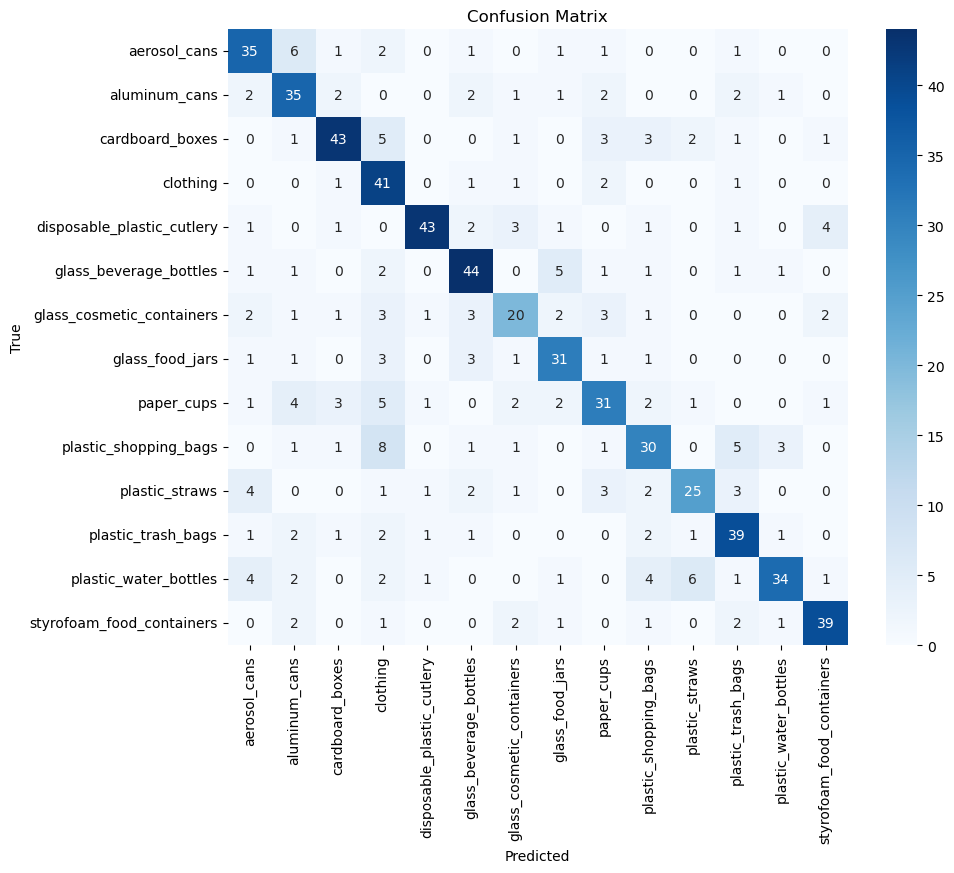

In [34]:
evaluator.ConfusionMatrix()

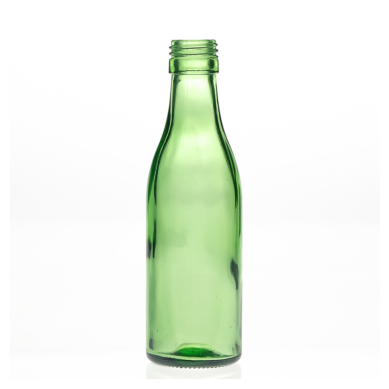

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class: glass_beverage_bottles


In [57]:
new_image_path = 'R.jpeg'
new_image = cv2.imread(new_image_path)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(new_image_rgb, (256, 256)) / 255.0
plt.imshow(new_image_rgb)
plt.axis('off') 
plt.show()
input_image = np.expand_dims(resized_img, axis=0)
prediction = cnnmodel.predict(input_image)
predicted_class_index = np.argmax(prediction)

predicted_class = class_names[predicted_class_index]

print("Predicted Class:", predicted_class)

### DenseNet 169

In [ ]:
DenseNet169_base = DenseNet169(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
for layer in DenseNet169_base.layers[:80]:
    layer.trainable = False

In [ ]:
x = Flatten()(DenseNet169_base.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
densenet_model = Model(inputs=DenseNet169_base.input, outputs=output)
densenet_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, mode='min')

In [ ]:
history = densenet_model.fit(train_generator, epochs=15, validation_data=(X_val, y_val), 
                             callbacks=[early_stopping, reduce_lr])

Epoch 1/15


C:\Users\i\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 1894s 14s/step - accuracy: 0.3449 - loss: 2.6850 - val_accuracy: 0.7475 - val_loss: 0.9932 - learning_rate: 1.0000e-04
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1208s 10s/step - accuracy: 0.7238 - loss: 0.9371 - val_accuracy: 0.7937 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1192s 10s/step - accuracy: 0.7973 - loss: 0.6351 - val_accuracy: 0.8325 - val_loss: 0.6142 - learning_rate: 1.0000e-04
Epoch 4/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1211s 10s/step - accuracy: 0.8840 - loss: 0.3777 - val_accuracy: 0.8475 - val_loss: 0.5665 - learning_rate: 1.0000e-04
Epoch 5/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1187s 10s/step - accuracy: 0.9062 - loss: 0.3009 - val_accuracy: 0.8712 - val_loss: 0.5875 - learning_rate: 1.0000e-04
Epoch 6/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1224s 10s/step - accuracy: 0.9269 - loss: 0.2251 - val_accuracy: 0.8612 - val_loss: 0.6282 - learning_rate: 1.0000e-04
Epoch 7/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1185s 10s/step - 

In [ ]:
densenet_model.save('DenseNet169_MODEL.h5')

In [ ]:
densenet_model = load_model('DenseNet169_MODEL.h5')

test_loss, test_accuracy = densenet_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f'DenseNet169 Test accuracy: {test_accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.8833 - loss: 0.5655
DenseNet169 Test accuracy: 0.8924999833106995


In [ ]:
evaluator = Evaluation(densenet_model, X_test, y_test, class_names)

25/25 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step


In [ ]:
evaluator.ClassificationReport()

                            precision    recall  f1-score   support

              aerosol_cans       1.00      0.87      0.93        63
             aluminum_cans       0.92      0.93      0.93        60
           cardboard_boxes       0.88      0.97      0.93        39
                  clothing       0.91      0.91      0.91        47
disposable_plastic_cutlery       0.98      0.93      0.96        59
    glass_beverage_bottles       0.96      0.83      0.89        53
 glass_cosmetic_containers       0.93      0.93      0.93        58
           glass_food_jars       0.86      0.84      0.85        43
                 newspaper       0.75      0.73      0.74        41
                paper_cups       0.87      0.92      0.89        63
   plastic_food_containers       0.86      0.86      0.86        44
     plastic_shopping_bags       0.88      0.91      0.89        46
            plastic_straws       0.80      0.93      0.86        44
        plastic_trash_bags       0.91      0.85

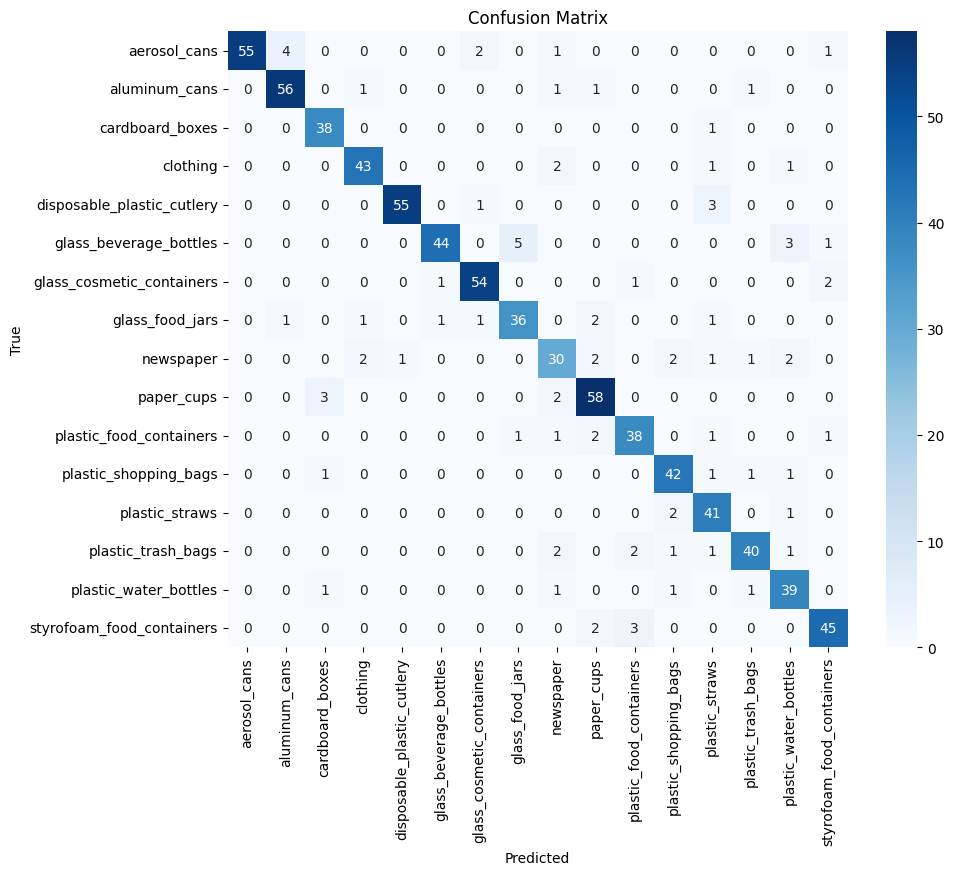

In [ ]:
evaluator.ConfusionMatrix()

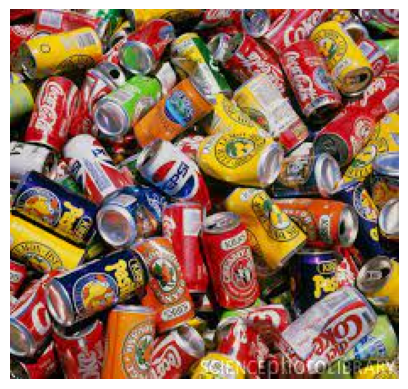

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
Predicted Class: aluminum_cans


In [ ]:
new_image_path = 'd.jpg'
new_image = cv2.imread(new_image_path)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(new_image_rgb, (256, 256)) / 255.0
plt.imshow(new_image_rgb)
plt.axis('off') 
plt.show()
input_image = np.expand_dims(resized_img, axis=0)
prediction = densenet_model.predict(input_image)
predicted_class_index = np.argmax(prediction)

predicted_class = class_names[predicted_class_index]

print("Predicted Class:", predicted_class)

### InceptionResNetV2

In [10]:
for layer in InceptionResNetV2_base.layers[:-20]:
    layer.trainable = False

In [12]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = InceptionResNetV2_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

In [13]:
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
checkpoint = ModelCheckpoint('InceptionResNetV2.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

In [17]:
history = model.fit(train_generator, validation_data=(X_val, y_val),epochs=50, callbacks=[checkpoint, early_stop])

Epoch 1/50


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.4853 - loss: 1.6436 - val_accuracy: 0.7714 - val_loss: 1.3781
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7854 - loss: 0.6968 - val_accuracy: 0.7400 - val_loss: 1.9041
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8332 - loss: 0.5337 - val_accuracy: 0.7614 - val_loss: 1.1428
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.8735 - loss: 0.4162 - val_accuracy: 0.8343 - val_loss: 0.6961
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.8845 - loss: 0.3907 - val_accuracy: 0.8314 - val_loss: 0.8341
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8922 - loss: 0.3520 - val_accuracy: 0.8243 - val_loss: 0.8880
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9094 - loss: 0.2921 - val_accuracy: 0.8514 - val_loss: 0.6490
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9260 - loss: 0.2304 - val_accuracy: 0.8557 - val_loss: 0.

In [ ]:
InceptionResNetV2_model = load_model('InceptionResNetV2.keras')

test_loss, test_accuracy = InceptionResNetV2_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Found 3500 images belonging to 14 classes.


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9345 - loss: 0.3738
Test accuracy: 93.29%


In [65]:
evaluator = Evaluation(InceptionResNetV2_model, X_test, y_test, class_names)

22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step


In [67]:
evaluator.ClassificationReport()

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.81      0.88      0.84        48
             aluminum_cans       0.87      0.81      0.84        48
           cardboard_boxes       0.93      0.90      0.92        60
                  clothing       0.94      0.94      0.94        47
disposable_plastic_cutlery       0.98      0.98      0.98        57
    glass_beverage_bottles       0.94      0.86      0.90        57
 glass_cosmetic_containers       0.93      0.95      0.94        39
           glass_food_jars       0.95      0.93      0.94        42
                paper_cups       0.91      0.96      0.94        53
     plastic_shopping_bags       0.88      0.90      0.89        51
            plastic_straws       0.83      0.83      0.83        42
        plastic_trash_bags       0.89      0.92      0.90        51
     plastic_water_bottles       0.80      0.80      0.80        56
 styrofoam_food_containe

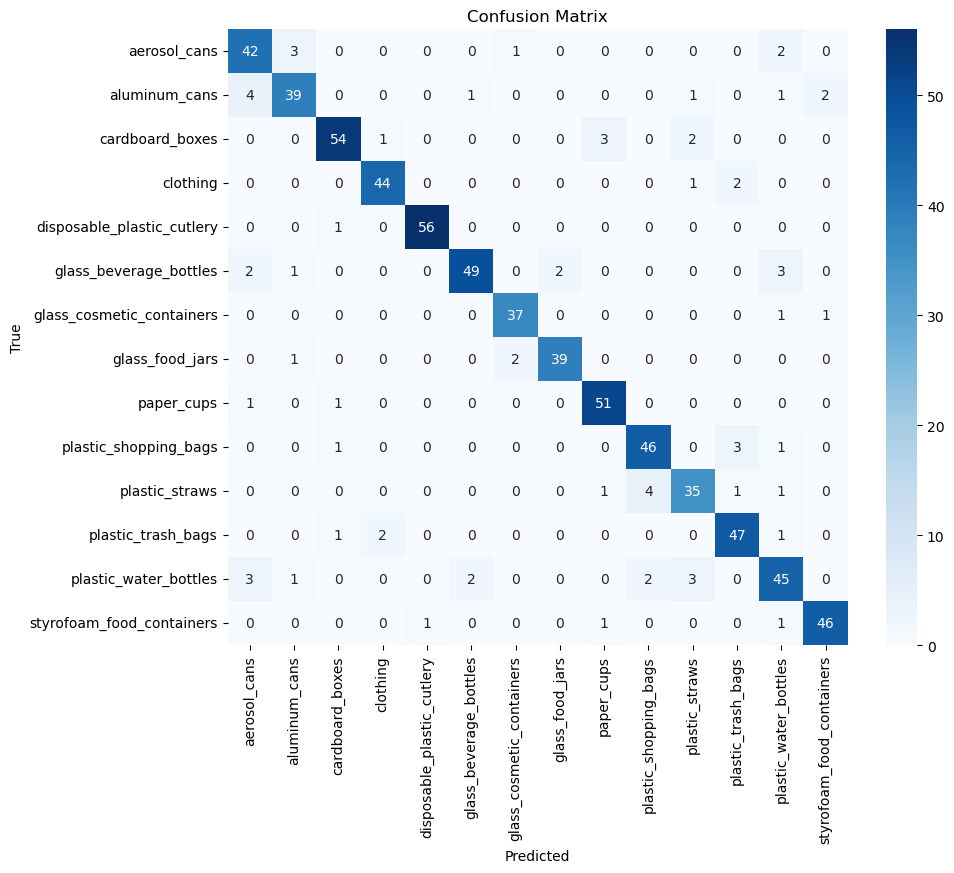

In [66]:
evaluator.ConfusionMatrix()

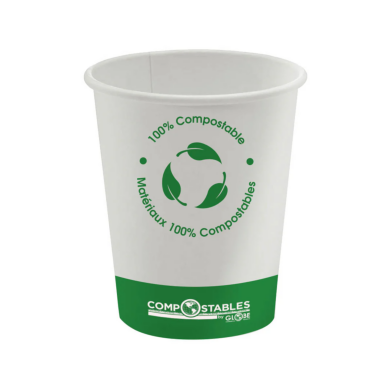

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted Class: paper_cups


In [68]:
new_image_path = 'cup.webp'
new_image = cv2.imread(new_image_path)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(new_image_rgb, (256, 256)) / 255.0
plt.imshow(new_image_rgb)
plt.axis('off') 
plt.show()
input_image = np.expand_dims(resized_img, axis=0)
prediction = InceptionResNetV2_model.predict(input_image)
predicted_class_index = np.argmax(prediction)

predicted_class = class_names[predicted_class_index]

print("Predicted Class:", predicted_class)

### VGG 19

In [ ]:
VGG19_base = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
datagen = ImageDataGenerator(rescale=0.255)

data_generator = datagen.flow_from_directory(DATASET_PATH, target_size=IMAGE_SIZE, batch_size=32, class_mode=None, shuffle=False)

features = VGG19_base.predict(data_generator, steps=len(data_generator), verbose=1)

Found 3500 images belonging to 14 classes.


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 1012s 9s/step


In [ ]:
np.save('vgg19_features2.npy', features)
np.save('vgg19_labels2.npy', data_generator.classes)

In [ ]:
features = np.load('vgg19_features2.npy')
labels = np.load('vgg19_labels2.npy')

In [ ]:
labels = to_categorical(labels, num_classes=NUM_CLASSES)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
model = Sequential([
    Flatten(input_shape=features.shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

c:\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)
test_loss, test_accuracy = model.evaluate(X_val, y_val)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.4655 - loss: 8.1122 - val_accuracy: 0.7729 - val_loss: 0.8542
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.7990 - loss: 0.7634 - val_accuracy: 0.8071 - val_loss: 0.9199
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8601 - loss: 0.5666 - val_accuracy: 0.8286 - val_loss: 0.8547
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8707 - loss: 0.5646 - val_accuracy: 0.8243 - val_loss: 0.7856
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8778 - loss: 0.5397 - val_accuracy: 0.8457 - val_loss: 0.7175
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9099 - loss: 0.3995 - val_accuracy: 0.8386 - val_loss: 0.7947
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9106 - loss: 0.4636 - val_accuracy: 0.8414 - val_loss: 0.9215
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9180 - loss: 0.4009 - val_accuracy: 0.8457 - v

In [ ]:
print(f'Test accuracy: {test_accuracy}')
model.save('vgg19_FINALLL2.h5')

Test accuracy: 0.8557142615318298


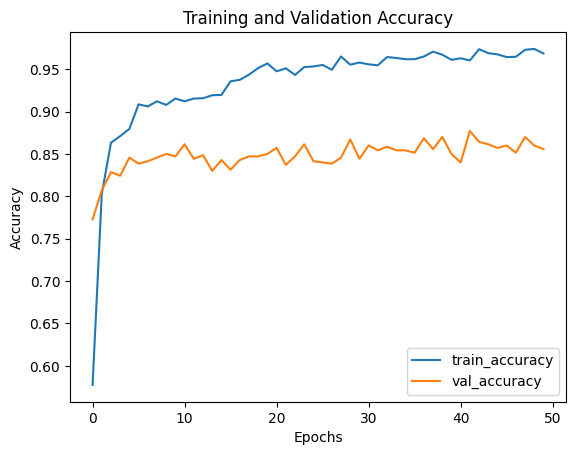

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
saved_model = load_model('vgg19_FINALLL2.h5')
new_image_path = 'image4.jpg'  
new_image = cv2.imread(new_image_path)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

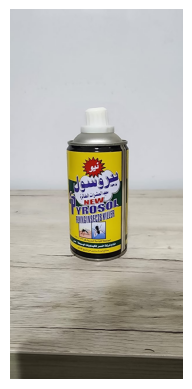

In [ ]:
plt.imshow(new_image_rgb)
plt.axis('off') 
plt.show()

In [ ]:
new_image = cv2.imread(new_image_path)
resized_image = cv2.resize(new_image, (256, 256))  
input_image = np.expand_dims(resized_image, axis=0)
input_image = preprocess_input(input_image)

In [ ]:
features = VGG19_base.predict(input_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


In [ ]:
prediction = saved_model.predict(features)
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class: aerosol_cans


In [ ]:
# Classification Report
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.77      0.77      0.77        62
             aluminum_cans       0.81      0.89      0.85        64
           cardboard_boxes       0.89      0.96      0.92        50
                  clothing       0.90      0.96      0.93        55
disposable_plastic_cutlery       0.94      0.87      0.90        52
    glass_beverage_bottles       0.80      0.81      0.80        43
 glass_cosmetic_containers       0.88      0.84      0.86        50
           glass_food_jars       0.91      0.78      0.84        51
                paper_cups       0.89      0.84      0.86        37
     plastic_shopping_bags       0.80      0.94      0.86        50
            plastic_straws       0.86      0.82      0.84        39
        plastic_trash_bags       1.00      0.78      0.88        50
     plastic_water_bottles       0.78      0.81      

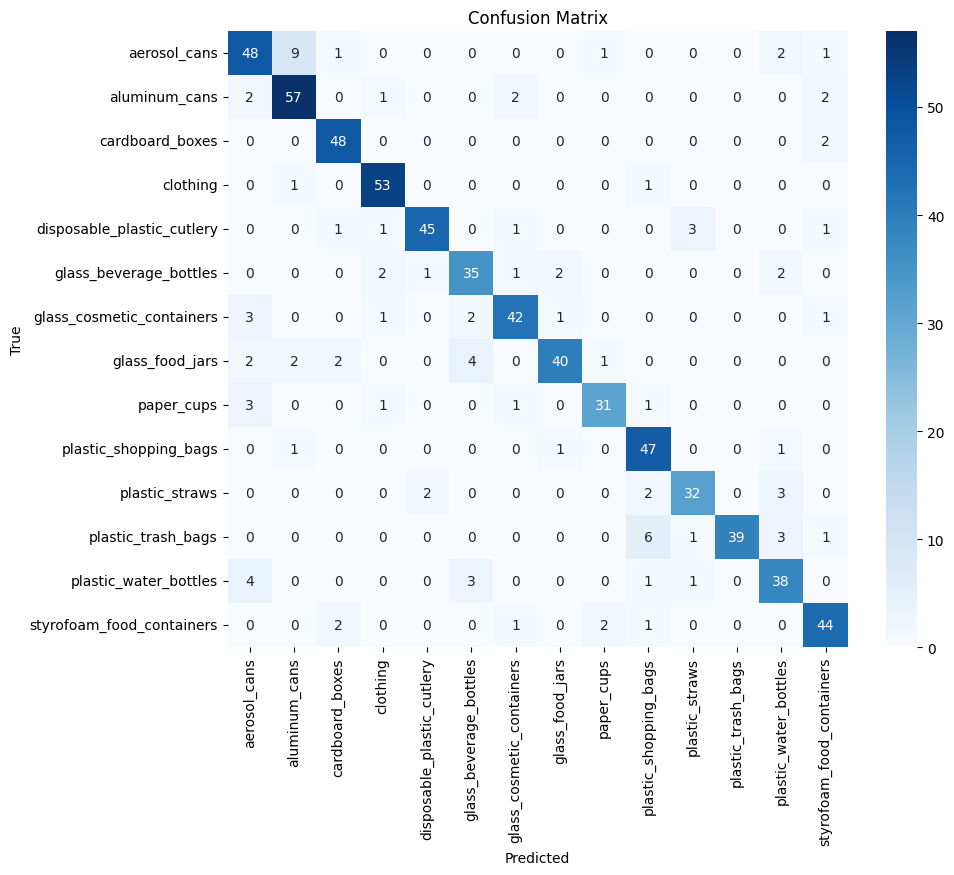

In [ ]:
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Inception v3

In [32]:
for layer in inceptionv3_base.layers[:-20]:
    layer.trainable = False

In [33]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = inceptionv3_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

In [34]:
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
checkpoint = ModelCheckpoint('InceptionV3_5.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

In [36]:
history = model.fit(train_generator, validation_data=(X_val, y_val),epochs=50, callbacks=[checkpoint, early_stop])

Epoch 1/50


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 88s 767ms/step - accuracy: 0.4626 - loss: 1.7514 - val_accuracy: 0.8000 - val_loss: 0.6185
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 83s 777ms/step - accuracy: 0.7511 - loss: 0.8401 - val_accuracy: 0.8429 - val_loss: 0.4951
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 771ms/step - accuracy: 0.8059 - loss: 0.6001 - val_accuracy: 0.8443 - val_loss: 0.5069
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 771ms/step - accuracy: 0.8424 - loss: 0.5119 - val_accuracy: 0.8800 - val_loss: 0.4705
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 763ms/step - accuracy: 0.8598 - loss: 0.4503 - val_accuracy: 0.8686 - val_loss: 0.4930
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 770ms/step - accuracy: 0.8779 - loss: 0.3873 - val_accuracy: 0.8643 - val_loss: 0.4656
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 83s 776ms/step - accuracy: 0.8792 - loss: 0.3905 - val_accuracy: 0.8629 - val_loss: 0.4804
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 83s 778ms/step - accuracy: 0.8992 - loss: 0.3116 - val

In [44]:
InceptionV3_model = load_model('InceptionV3_5.keras')

test_loss, test_accuracy = InceptionV3_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f'InceptionV3 Test accuracy: {test_accuracy}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 546ms/step - accuracy: 0.8605 - loss: 0.5054
InceptionV3 Test accuracy: 0.8799999952316284


In [37]:
evaluator = Evaluation(imodel, X_test, y_test, class_names)

22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 863ms/step


In [38]:
evaluator.ClassificationReport()

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.89      0.81      0.85        48
             aluminum_cans       0.88      0.94      0.91        48
           cardboard_boxes       0.98      0.92      0.95        60
                  clothing       0.91      0.91      0.91        47
disposable_plastic_cutlery       0.90      0.95      0.92        57
    glass_beverage_bottles       0.85      0.91      0.88        57
 glass_cosmetic_containers       1.00      0.87      0.93        39
           glass_food_jars       0.83      0.93      0.88        42
                paper_cups       0.86      0.96      0.91        53
     plastic_shopping_bags       0.91      0.78      0.84        51
            plastic_straws       0.89      0.74      0.81        42
        plastic_trash_bags       0.72      0.90      0.80        51
     plastic_water_bottles       0.83      0.77      0.80        56
 styrofoam_food_containe

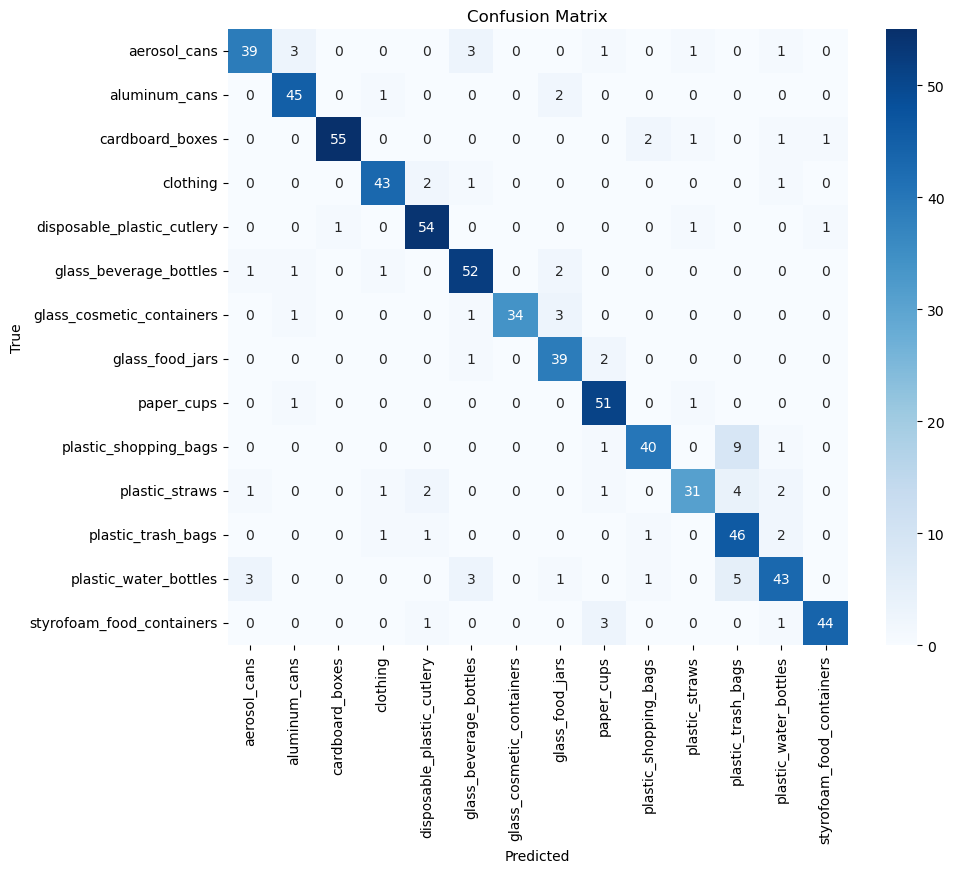

In [39]:
evaluator.ConfusionMatrix()

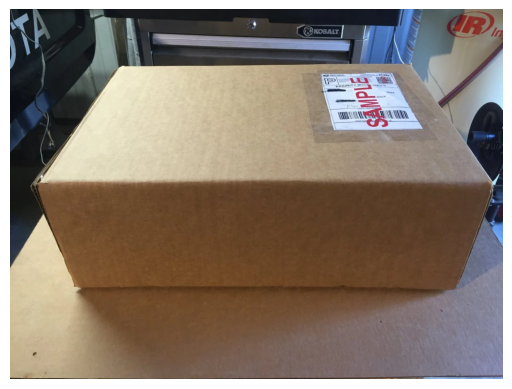

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: cardboard_boxes


In [45]:
new_image_path = 'carbox.webp'
new_image = cv2.imread(new_image_path)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(new_image_rgb, (256, 256)) / 255.0
plt.imshow(new_image_rgb)
plt.axis('off') 
plt.show()
input_image = np.expand_dims(resized_img, axis=0)
prediction = InceptionV3_model.predict(input_image)
predicted_class_index = np.argmax(prediction)

predicted_class = class_names[predicted_class_index]

print("Predicted Class:", predicted_class)

### Xception

In [ ]:
xception_base = Xception(weights="imagenet", include_top=False, input_shape=(256,256,3))

for layer in xception_base.layers:
    layer.trainable = False
    
for layer in xception_base.layers[-5:]:
    layer.trainable = True
    
x = xception_base.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5) 

Xception_model = Model(inputs=xception_base.input, outputs=predictions)
Xception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
histroy=Xception_model.fit(
    train_generator,  
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/15
75/75 [==============================] - 405s 5s/step - loss: 16.3735 - accuracy: 0.6842 - val_loss: 20.5385 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 2/15
75/75 [==============================] - 389s 5s/step - loss: 8.6431 - accuracy: 0.7583 - val_loss: 12.7751 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 3/15
75/75 [==============================] - 353s 5s/step - loss: 4.9681 - accuracy: 0.8200 - val_loss: 10.8392 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 4/15
75/75 [==============================] - 349s 5s/step - loss: 4.0913 - accuracy: 0.8263 - val_loss: 9.5724 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 5/15
75/75 [==============================] - 349s 5s/step - loss: 2.9101 - accuracy: 0.8596 - val_loss: 10.1714 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 6/15
75/75 [==============================] - 342s 5s/step - loss: 2.3526 - accuracy: 0.8721 - val_loss: 8.1624 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 7/15
75/75 [==============================] - 338s 5s/step - loss

In [ ]:
Xception_model.save("Xception_finetuned_imagenet_v3.keras")

In [ ]:
test_loss, test_accuracy = Xception_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f'Xception Test accuracy: {test_accuracy}')

25/25 [==============================] - 50s 2s/step - loss: 4.7596 - accuracy: 0.8213
Xception Test accuracy: 0.8212500214576721


In [ ]:
y_pred = Xception_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 51s 2s/step


In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                            precision    recall  f1-score   support

              aerosol_cans       0.85      0.84      0.85        63
             aluminum_cans       0.84      0.80      0.82        60
           cardboard_boxes       0.88      0.92      0.90        39
                  clothing       0.85      0.74      0.80        47
disposable_plastic_cutlery       0.94      0.86      0.90        59
    glass_beverage_bottles       0.82      0.79      0.81        53
 glass_cosmetic_containers       0.76      0.83      0.79        58
           glass_food_jars       0.71      0.79      0.75        43
                 newspaper       0.76      0.61      0.68        41
                paper_cups       0.82      0.87      0.85        63
   plastic_food_containers       0.76      0.84      0.80        44
     plastic_shopping_bags       0.81      0.85      0.83        46
            plastic_straws       0.82      0.91      0.86        44
        plastic_trash_bags       0.82      0.85

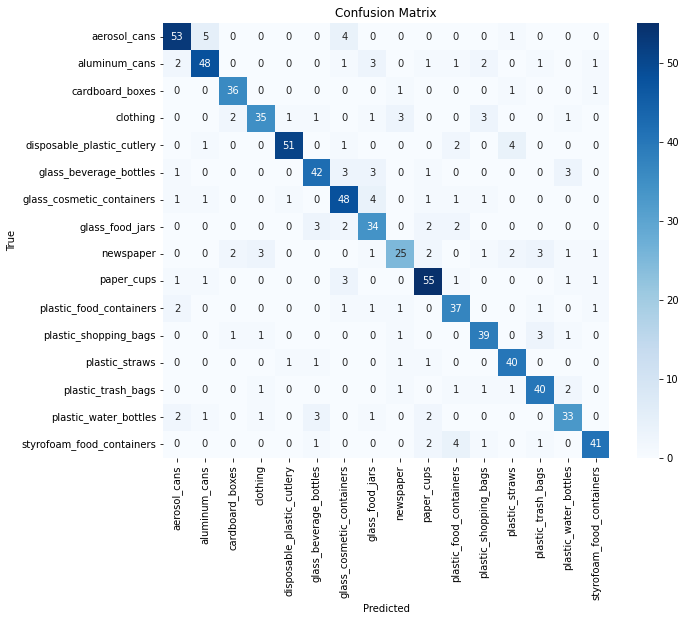

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
saved_model = load_model('Xception_finetuned_imagenet_v3.keras')

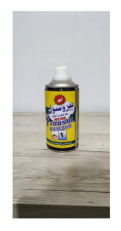

In [ ]:
new_image_path = 'download.png'  
new_image = cv2.imread(new_image_path)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
resized_img = cv2.resize(new_image_rgb, (256, 256)) / 255.0
plt.imshow(new_image_rgb)
plt.axis('off') 
plt.show()

In [ ]:
prediction = Xception_model.predict(np.expand_dims(resized_img, axis=0))

predicted_class_index = np.argmax(prediction)

predicted_class = class_names[predicted_class_index]

print("Predicted Class:", predicted_class)


1/1 [==============================] - 1s 1s/step
Predicted Class: aerosol_cans


<div style="font-weight: bold; text-align: center"> <font size="12", color='darkblue'> Interface </font> </div>

In [ ]:
model = load_model('InceptionResNetV2.keras')

In [40]:
from PIL import Image
import gradio as gr

# model = load_model('InceptionResNetV2.keras')

def predict(image):
    image = image.resize((256, 256))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    return {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}

interface = gr.Interface(
    fn=predict, 
    inputs=gr.Image(type="pil"),  
    outputs=gr.Label() 
)

In [41]:
interface.launch()

Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [42]:
interface.close()

Closing server running on port: 7869


### EfficientNetB7

In [13]:
EfficientNetB7_model = load_model('EfficientNetB7.keras')

test_loss, test_accuracy = EfficientNetB7_model.evaluate(X_test, y_test, batch_size=20)
print(f'EfficientNetB7 Test accuracy: {test_accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.0554 - loss: 2.7778
EfficientNetB7 Test accuracy: 0.05874999985098839


### NASNetLarge

In [13]:
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE))
print('Test accuracy:', test_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 263s 10s/step - accuracy: 0.7995 - loss: 0.7779
Test accuracy: 0.7975000143051147


In [15]:
y_pred = model.predict(test_datagen.flow(X_test, batch_size=BATCH_SIZE))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 278s 11s/step


In [17]:
print('Classification Report')
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Classification Report
                            precision    recall  f1-score   support

              aerosol_cans       0.13      0.11      0.12        63
             aluminum_cans       0.08      0.08      0.08        60
           cardboard_boxes       0.10      0.10      0.10        39
                  clothing       0.05      0.04      0.05        47
disposable_plastic_cutlery       0.14      0.14      0.14        59
    glass_beverage_bottles       0.02      0.02      0.02        53
 glass_cosmetic_containers       0.00      0.00      0.00        58
           glass_food_jars       0.05      0.07      0.06        43
                 newspaper       0.07      0.07      0.07        41
                paper_cups       0.07      0.08      0.08        63
   plastic_food_containers       0.11      0.14      0.12        44
     plastic_shopping_bags       0.07      0.07      0.07        46
            plastic_straws       0.04      0.05      0.04        44
        plastic_trash_bag

### ResNet50V2

In [10]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step


In [17]:
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE))
print('Test accuracy:', test_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8584 - loss: 1.1907
Test accuracy: 0.8537499904632568


In [19]:
y_pred = model.predict(test_datagen.flow(X_test, batch_size=BATCH_SIZE))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Classification Report
                            precision    recall  f1-score   support

              aerosol_cans       0.04      0.03      0.03        63
             aluminum_cans       0.12      0.13      0.12        60
           cardboard_boxes       0.04      0.05      0.04        39
                  clothing       0.06      0.06      0.06        47
disposable_plastic_cutlery       0.07      0.07      0.07        59
    glass_beverage_bottles       0.11      0.09      0.10        53
 glass_cosmetic_containers       0.05      0.05      0.05        58
           glass_food_jars       0.05      0.05      0.05        43
                 newspaper       0.03      0.02      0.03        41
                paper_cups       0.08      0.08      0.08        63
   plastic_food_containers       0.02      0.02      0.02        44
     plastic_shopping_bags       0.07      0.07      0.07        46
            plastic_straws       0.10      0.11      0.11        44
        plastic_trash_bag